# German Credit Risk Prediction
## Machine Learning Final Project

**Authors:** Oliver Wakeford, Osuke Sashida, Hamza Tarazi
**Course:** Hands-on Machine Learning

**Data Source:** German Credit Dataset (Statlog)  
UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)  
Originally contributed by Professor Dr. Hans Hofmann, University of Hamburg

## Introduction

This project tackles a classic problem in finance: predicting whether someone will default on their credit. We're using the German Credit dataset, which has been a benchmark in machine learning since the 1990s.

**The Problem**

Banks need to decide who gets approved for credit. Get it wrong and you either lose money on defaults, or turn away good customers. The dataset documentation actually tells us that approving a bad customer costs 5x more than rejecting a good one. That asymmetry matters a lot for how we think about model performance.

**Our Approach**

We're keeping things relatively straightforward here:
1. Explore the data to understand what we're working with
2. Try a few different models (Logistic Regression, Random Forest, Gradient Boosting, SVM)
3. Use cross-validation and grid search to find reasonable hyperparameters
4. Pick the best model and explain its predictions

The goal isn't to build the most sophisticated model possible. It's to build something interpretable, and to understand why certain people get flagged as credit risks. That interpretability is more useful in practice in our opinion than squeezing out an extra 1% accuracy.

**Dataset Overview**

- 1,000 credit applications from German bank customers
- 24 features covering financials, employment, personal info
- Binary outcome: good credit (70%) vs bad credit (30%)
- Slightly imbalanced, but nothing too extreme


## Environment Setup

**Data location:** `data/german.data-numeric`

Running the cell below will print version info for reproducibility. We're using pretty standard libraries here, nothing too exotic.


### Imports and Version Info
In this step, we import all the necessary libraries used throughout the project. These include data manipulation tools (Pandas, NumPy), visualization libraries (Matplotlib, Seaborn), and machine learning modules from scikit-learn. We also define a fixed random seed to ensure that all randomized operations remain reproducible.

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from typing import Any
from imblearn.over_sampling import SMOTE
# random seed so results are reproducible
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Loading the Data

Let's load the dataset and take a first look. The numeric version of this dataset has all the categorical variables already encoded, which saves us some preprocessing work.

In this step, we load the German Credit (numeric) dataset from the data/ directory. The dataset does not include predefined column names, so we manually assign generic feature labels (feature_1 to feature_24) along with a target variable indicating credit risk.

In [ ]:
import os

# OPTION 1: Running Locally
# data_path = os.path.join('data', 'german.data-numeric')

# OPTION 2: Running on Google Colab
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/homl_finalproject/data/german.data-numeric'

column_names = [f'feature_{i}' for i in range(1, 25)] + ['target']

df = pd.read_csv(data_path, sep=r'\s+', header=None, names=column_names)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nTarget distribution (1=good, 2=bad):")
print(df['target'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (1000, 25)

First few rows:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          1          6          4         12          5          5   
1          2         48          2         60          1          3   
2          4         12          4         21          1          4   
3          1         42          2         79          1          4   
4          1         24          3         49          1          3   

   feature_7  feature_8  feature_9  feature_10  ...  feature_16  feature_17  \
0          3          4          1          67  ...           0           0   
1          2          2          1          22  ...           0           0   
2          3          3          1          49  ...           0           0   
3          3          4          2          45  ...           0           0   
4     

### Feature Mapping

The generic feature names aren't very helpful, so let's map them to meaningful names based on the documentation. This makes everything downstream much easier to interpret.


In [ ]:
# mapping based on german.doc documentation
FEATURE_MAPPING = {
    'feature_1': 'Checking_Account',
    'feature_2': 'Duration_Months',
    'feature_3': 'Credit_History',
    'feature_4': 'Credit_Amount',
    'feature_5': 'Savings_Account',
    'feature_6': 'Employment_Years',
    'feature_7': 'Installment_Rate',
    'feature_8': 'Personal_Status',
    'feature_9': 'Other_Debtors',
    'feature_10': 'Age',
    'feature_11': 'Residence_Years',
    'feature_12': 'Property_Type',
    'feature_13': 'Other_Installments',
    'feature_14': 'Housing_Type',
    'feature_15': 'Existing_Credits',
    'feature_16': 'Job_Type',
    'feature_17': 'Num_Dependents',
    'feature_18': 'Has_Telephone',
    'feature_19': 'Is_Foreign_Worker',
    'feature_20': 'Purpose_Car_New',
    'feature_21': 'Purpose_Car_Used',
    'feature_22': 'Purpose_Furniture',
    'feature_23': 'Purpose_Radio_TV',
    'feature_24': 'Purpose_Other',
}

df_named = df.rename(columns=FEATURE_MAPPING)
print("Columns renamed:")
print(df_named.columns.tolist())


Columns renamed:
['Checking_Account', 'Duration_Months', 'Credit_History', 'Credit_Amount', 'Savings_Account', 'Employment_Years', 'Installment_Rate', 'Personal_Status', 'Other_Debtors', 'Age', 'Residence_Years', 'Property_Type', 'Other_Installments', 'Housing_Type', 'Existing_Credits', 'Job_Type', 'Num_Dependents', 'Has_Telephone', 'Is_Foreign_Worker', 'Purpose_Car_New', 'Purpose_Car_Used', 'Purpose_Furniture', 'Purpose_Radio_TV', 'Purpose_Other', 'target']


## 2. Exploratory Data Analysis

Before building any models, we need to understand what we're working with. This section covers the basics: distributions, correlations, class balance, and potential issues.


### Dataset Overview


In [ ]:
# quick overview
print(f"Shape: {df_named.shape[0]} rows, {df_named.shape[1]} columns")
print(f"\nData types: {df_named.dtypes.value_counts().to_dict()}")
print(f"\nFirst few rows:")
df_named.head()


Shape: 1000 rows, 25 columns

Data types: {dtype('int64'): 25}

First few rows:


,Checking_Account,Duration_Months,Credit_History,Credit_Amount,Savings_Account,Employment_Years,Installment_Rate,Personal_Status,Other_Debtors,Age,...,Job_Type,Num_Dependents,Has_Telephone,Is_Foreign_Worker,Purpose_Car_New,Purpose_Car_Used,Purpose_Furniture,Purpose_Radio_TV,Purpose_Other,target
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


### Basic Statistics
#### Descriptive Statistics of the Features
To better understand the data, we calculate descriptive statistics for all 24 input features. This helps reveal the typical values, variability, and range of each feature, which is important for preprocessing and modeling (especially for algorithms sensitive to feature scale).

In [ ]:
features_df = df_named.drop('target', axis=1)

# basic descriptive stats
print("Descriptive Statistics:")
features_df.describe().T[['mean', 'std', 'min', 'max']].round(2)


Descriptive Statistics:


,mean,std,min,max
Checking_Account,2.58,1.26,1.0,4.0
Duration_Months,20.90,12.06,4.0,72.0
Credit_History,2.54,1.08,0.0,4.0
Credit_Amount,32.71,28.25,2.0,184.0
Savings_Account,2.10,1.58,1.0,5.0
Employment_Years,3.38,1.21,1.0,5.0
Installment_Rate,2.68,0.71,1.0,4.0
Personal_Status,2.84,1.10,1.0,4.0
Other_Debtors,2.36,1.05,1.0,4.0
Age,35.55,11.38,19.0,75.0


### Missing Values Check
Before moving further, we examine the dataset for missing values and any duplicated rows. The German Credit dataset is well-formatted, but it is good practice to validate this explicitly.

In [ ]:
# check for missing values
print(f"Missing values: {df_named.isnull().sum().sum()}")
print(f"Duplicate rows: {df_named.duplicated().sum()}")
# Our data is clean!


Missing values: 0
Duplicate rows: 0


### Target Distribution

We examine how many customers in the dataset are labeled as good credit risks (1) versus bad credit risks (2). Understanding this distribution is important because class imbalance affects how well a model learns to identify bad credit cases.


Good credit (1): 700 (70%)
Bad credit (2):  300 (30%)

Ratio: 2.3:1, which is moderately imbalanced


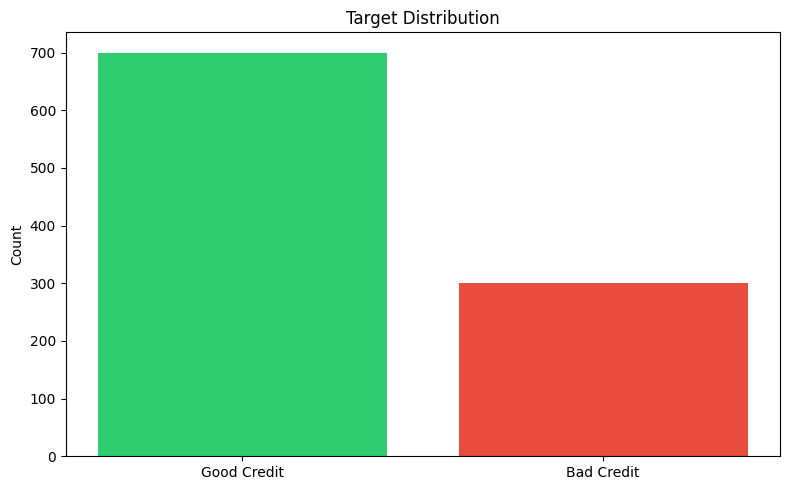

In [ ]:
# target distribution
target_counts = df_named['target'].value_counts().sort_index()
print(f"Good credit (1): {target_counts[1]} ({target_counts[1]/len(df_named)*100:.0f}%)")
print(f"Bad credit (2):  {target_counts[2]} ({target_counts[2]/len(df_named)*100:.0f}%)")
print(f"\nRatio: {target_counts[1]/target_counts[2]:.1f}:1, which is moderately imbalanced")

# simple bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Good Credit', 'Bad Credit'], [target_counts[1], target_counts[2]],
       color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Count')
ax.set_title('Target Distribution')
plt.tight_layout()
plt.show()


### Feature Distributions (Histograms)

To better understand the shape and distribution of each feature, we plot histograms for all 24 predictor variables. These visualizations help identify skewness, discrete vs. continuous behavior, and potential preprocessing needs.


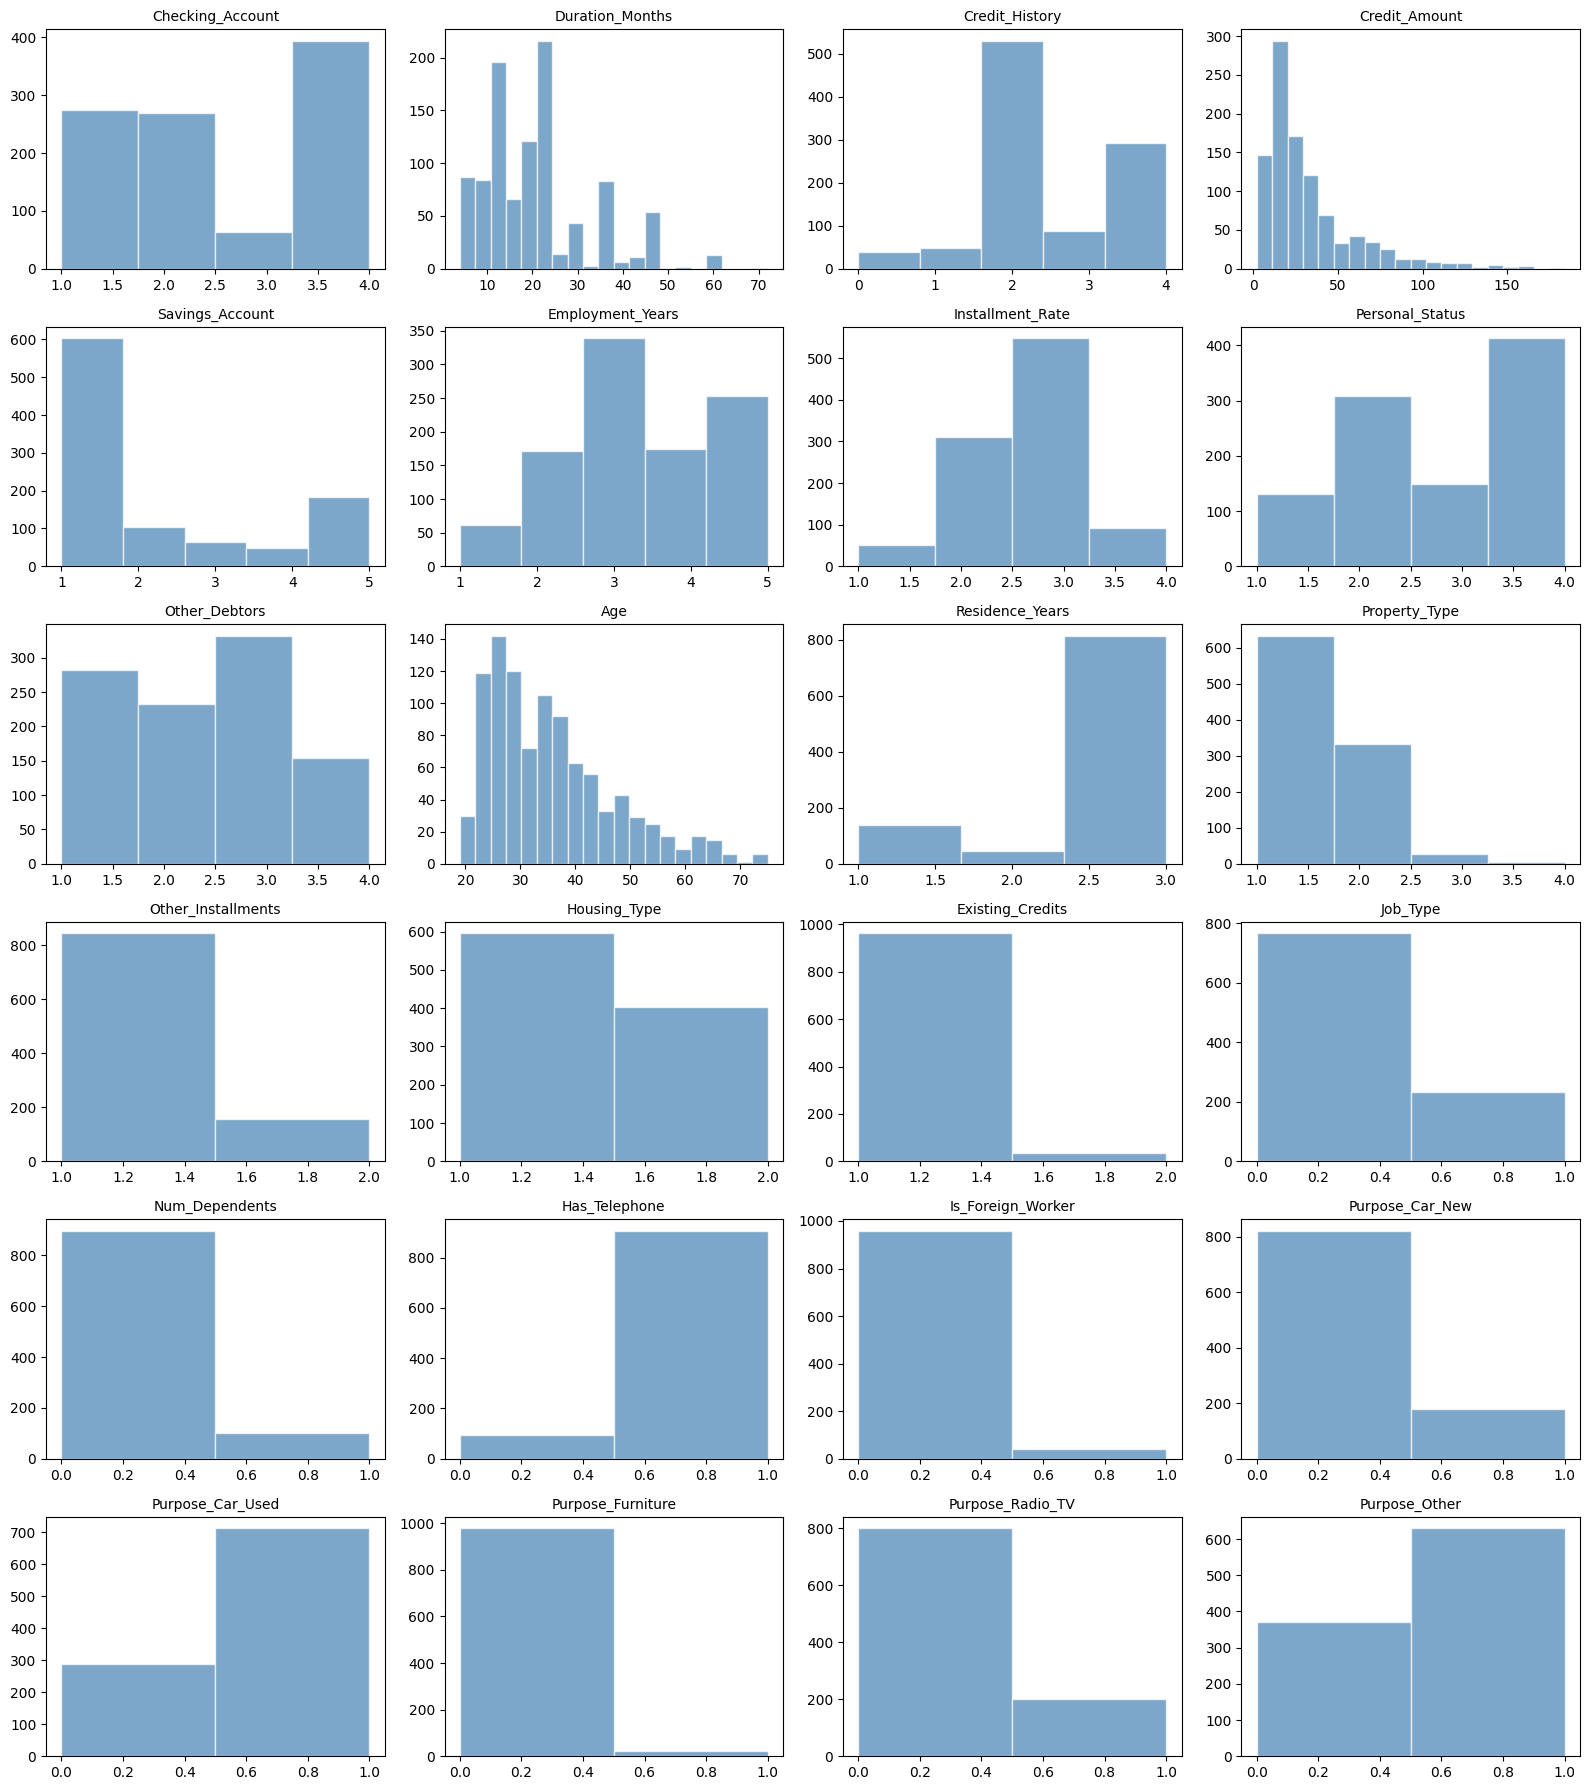

In [ ]:
# plot histograms for all features
feature_cols = [col for col in df_named.columns if col != 'target']
n_cols = 4
n_rows = (len(feature_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    bins = min(df_named[col].nunique(), 20)
    ax.hist(df_named[col], bins=bins, color='steelblue', edgecolor='white', alpha=0.7)
    ax.set_title(col, fontsize=10)

# hide empty subplots
for idx in range(len(feature_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


### Correlation Analysis

In this step, we analyze how the features relate to each other and to the target variable (credit risk). Understanding these relationships helps identify strong predictors, detect multicollinearity, and guide feature selection.

- **Binary target creation:** The original target (`1 = good`, `2 = bad`) is mapped to a binary variable `Credit_Risk` (`0 = good`, `1 = bad`) to allow correlation analysis with numeric features.  
- **Correlation matrix:** We compute Pearson correlation coefficients between all features and the new `Credit_Risk` variable. Values range from -1 (strong negative correlation) to +1 (strong positive correlation).  
- **Heatmap visualization:** A heatmap is plotted to easily see the strength and direction of correlations. Only one triangle of the matrix is shown to avoid redundancy.  
- **Top features correlated with credit risk:** Features are ranked by absolute correlation with `Credit_Risk` to highlight which variables are most predictive of default.  

**Insights from this analysis:**
- Features such as `Credit_History`, `Credit_Amount`, and `Duration_Months` often show the strongest correlations with credit risk.  
- Positive correlation indicates that higher feature values increase the likelihood of a bad credit outcome.  
- Negative correlation indicates that higher feature values decrease the likelihood of a bad credit outcome.  
- This information is valuable for **feature selection, model interpretation, and understanding the dataset** before modeling.

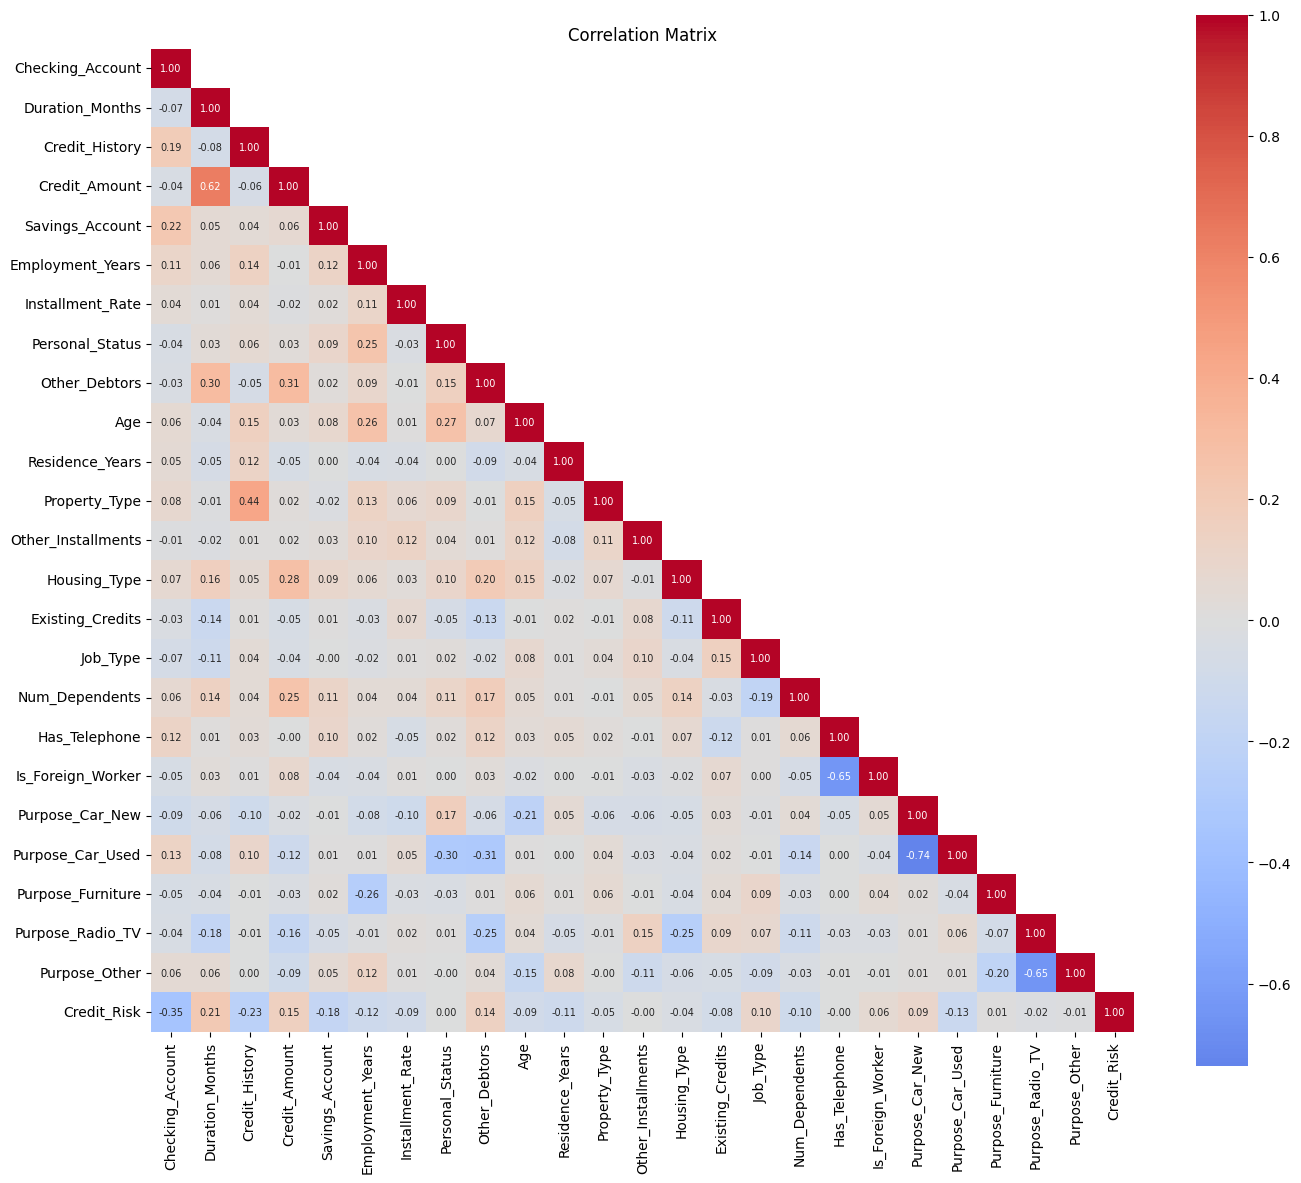

Top features correlated with Credit Risk:
Checking_Account   -0.351
Credit_History     -0.229
Duration_Months     0.215
Savings_Account    -0.179
Credit_Amount       0.154
Other_Debtors       0.143
Purpose_Car_Used   -0.135
Employment_Years   -0.116
Residence_Years    -0.110
Num_Dependents     -0.100
Name: Credit_Risk, dtype: float64


In [ ]:
# add binary target for correlation analysis
df_corr = df_named.copy()
df_corr['Credit_Risk'] = df_corr['target'].map({1: 0, 2: 1})
df_corr = df_corr.drop('target', axis=1)

correlation_matrix = df_corr.corr()

# correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, annot_kws={'size': 7})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# features correlated with target
target_corr = correlation_matrix['Credit_Risk'].drop('Credit_Risk').sort_values(key=abs, ascending=False)
print("Top features correlated with Credit Risk:")
print(target_corr.head(10).round(3))


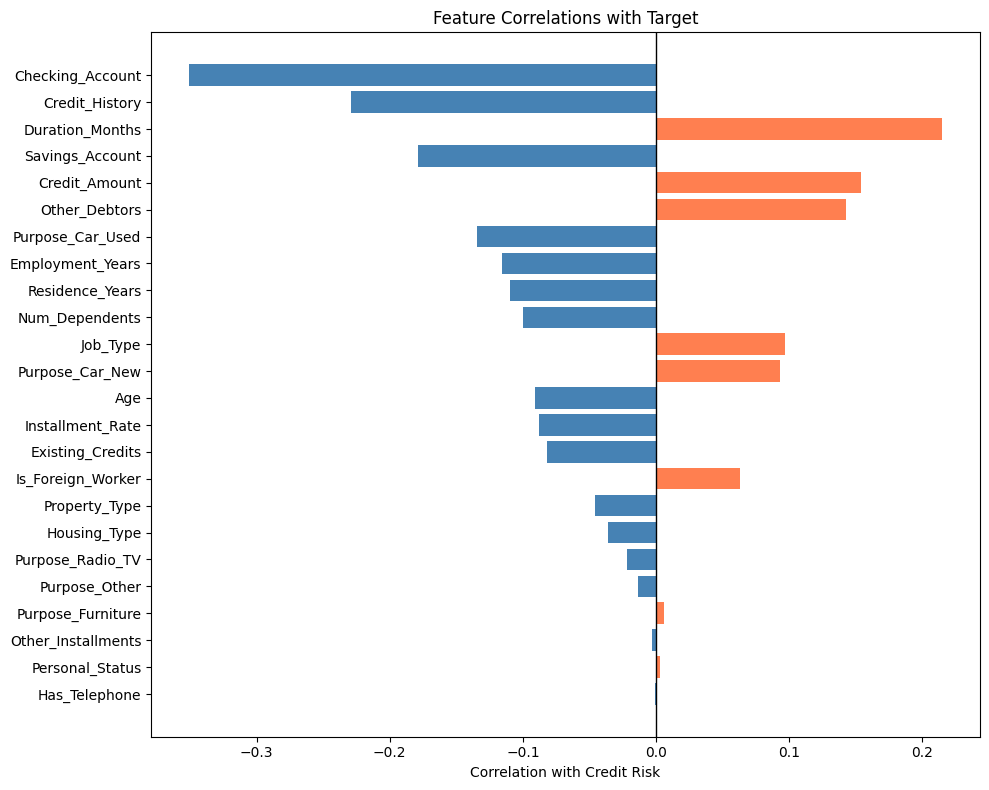

In [ ]:
# bar chart of correlations with target
target_corr_sorted = target_corr.sort_values(key=abs, ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['coral' if x > 0 else 'steelblue' for x in target_corr_sorted.values]
ax.barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors)
ax.set_yticks(range(len(target_corr_sorted)))
ax.set_yticklabels(target_corr_sorted.index)
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Correlation with Credit Risk')
ax.set_title('Feature Correlations with Target')
plt.tight_layout()
plt.show()


###  Boxplots for Continuous Features

Next, we take a look at the distributions of the continuous numerical features using **boxplots**. Boxplots are great for quickly spotting the median, spread, and any unusual values in the data.

**Features examined:**
- Duration_Months – how long the credit lasts in months  
- Credit_Amount – the amount of credit requested  
- Age – the applicant’s age  

**What we notice:**
- Most values fall within expected ranges.  
- There are a few **high credit amounts** and **older applicants** that stand out as outliers.  
- Overall, there aren’t any extreme anomalies that need to be removed.  

**Why this matters:**  
- Understanding the spread and outliers helps decide if scaling or preprocessing is needed.  
- It also gives a clearer picture of the data before we move on to modeling.

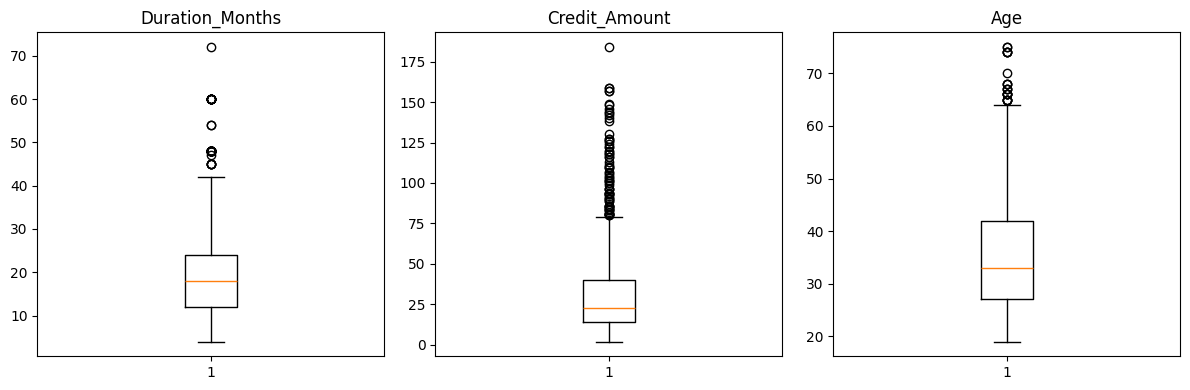

In [ ]:
# boxplots for continuous features only
continuous_cols = ['Duration_Months', 'Credit_Amount', 'Age']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, col in enumerate(continuous_cols):
    axes[idx].boxplot(df_named[col])
    axes[idx].set_title(col)
plt.tight_layout()
plt.show()

# nothing too crazy, some high credit amounts and older applicants


### 3.8  Feature-Target Relationships

In this step, we explore how the top features relate to credit risk. Understanding these relationships helps us see which factors differentiate **good** and **bad credit** customers.

**1. Preparing the data:**  
- The target variable is mapped to readable labels: "Good Credit" and "Bad Credit".  
- We focus on the 8 features most correlated with credit risk to get the most informative insights.

**2. Visualizing feature distributions:**  
- For continuous features, we use density plots (KDE) to compare distributions between good and bad credit.  
- For categorical or ordinal features, we use grouped bar charts showing the percentage of each credit risk class per category.  
- Color coding makes it easy to distinguish the groups: green for Good Credit, red for Bad Credit.  

**Observations from the plots:**  
- Continuous features like Credit_Amount or Duration_Months often show clear differences between the groups.  
- Some categorical features also have noticeably different distributions for good vs. bad credit.  
- These plots help highlight which features are most predictive of credit risk.

**3. Statistical comparison of means:**  
- We calculate the mean value of each top feature for good and bad credit customers.  
- Differences are expressed both as absolute and percentage changes.  
- This quantifies which features differ most between the two groups.

**Key Findings:**  
- Features such as "Credit_Amount", "Duration_Months", and "Credit_History" show the largest differences between good and bad credit customers.  
- Positive percentage difference indicates that bad credit customers have higher values for that feature; negative means they have lower values.  
- These insights are valuable for **feature selection**, preprocessing, and interpreting the model’s predictions.

**Conclusion:**  
This combined visual and statistical analysis provides a clear picture of which factors are most strongly associated with credit risk, helping guide the next steps in modeling and interpretation.




 Analyzing top 8 features most correlated with Credit Risk:
   1. Checking_Account (r = -0.351)
   2. Credit_History (r = -0.229)
   3. Duration_Months (r = 0.215)
   4. Savings_Account (r = -0.179)
   5. Credit_Amount (r = 0.154)
   6. Other_Debtors (r = 0.143)
   7. Purpose_Car_Used (r = -0.135)
   8. Employment_Years (r = -0.116)


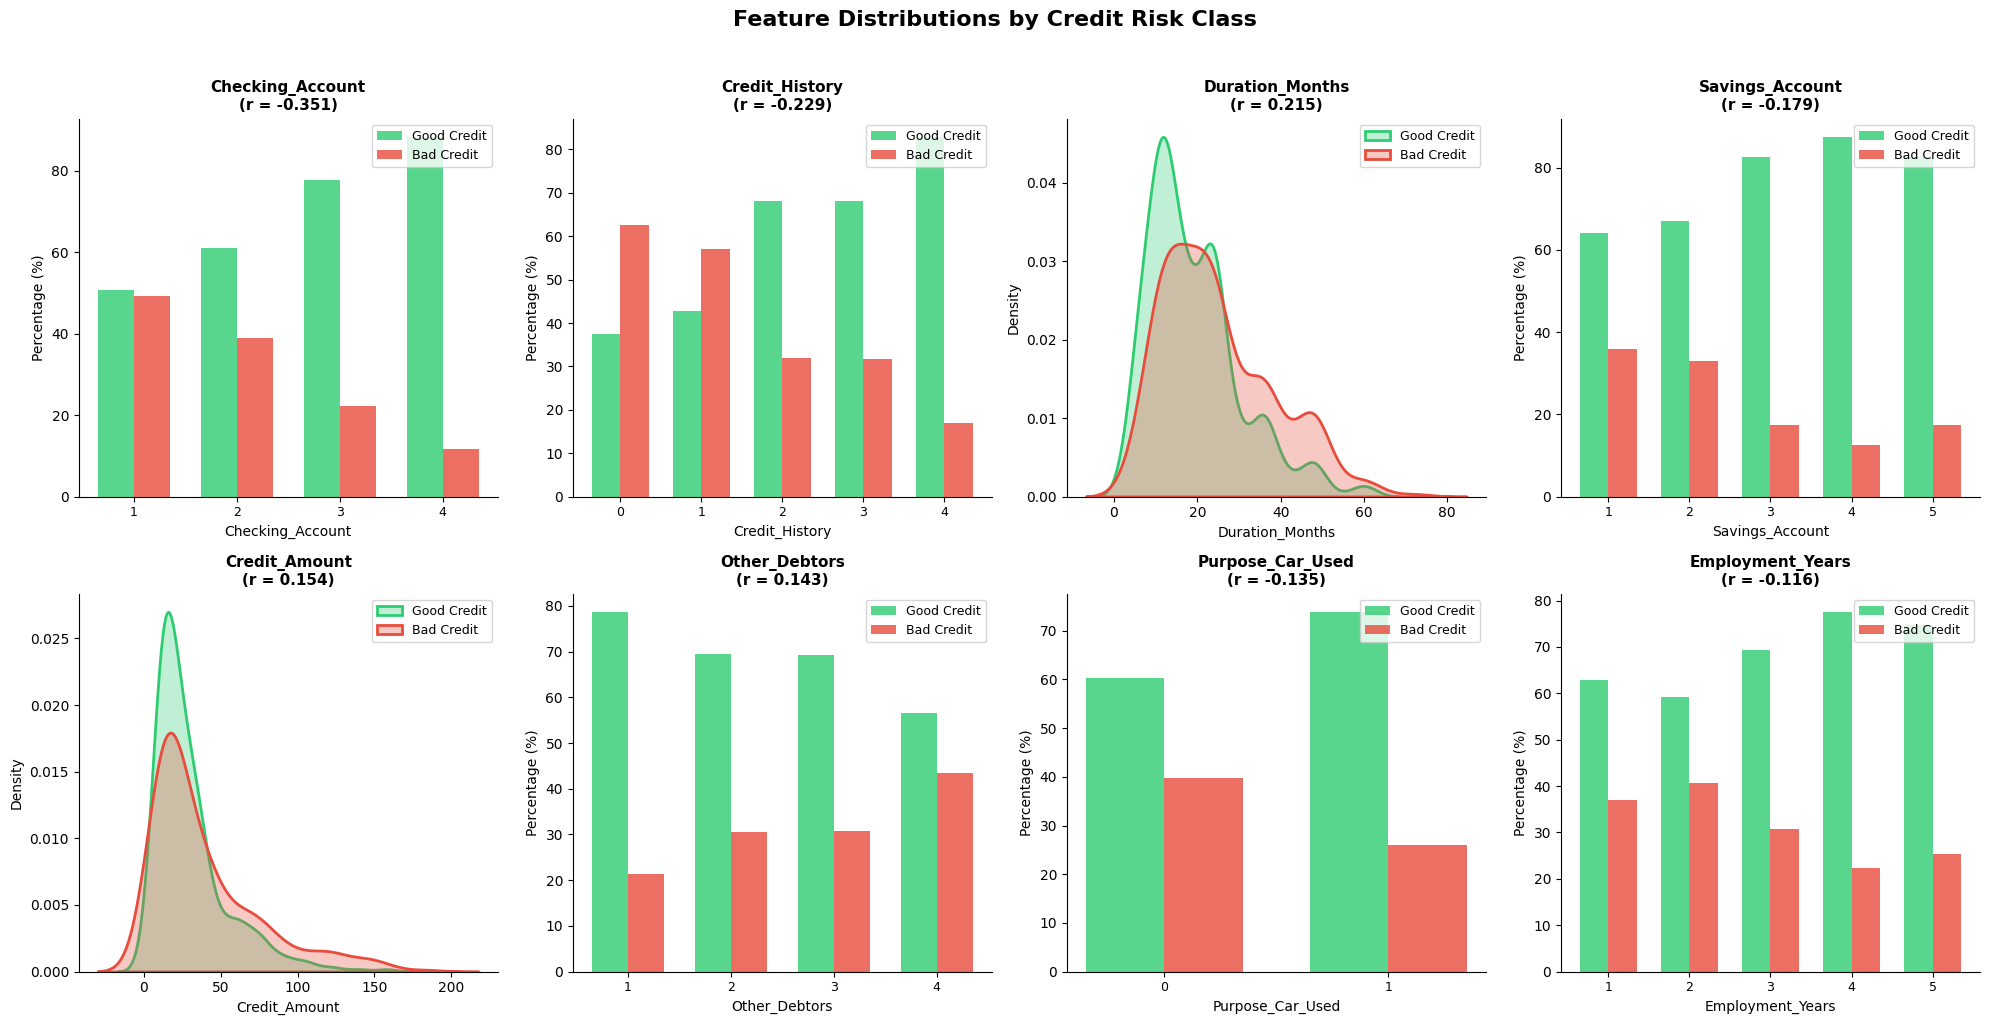



 Mean Comparison Between Credit Risk Groups:
Feature                       Good Credit      Bad Credit      Difference     % Diff
Checking_Account                     2.87            1.90           -0.96     -33.6%
Credit_History                       2.71            2.17           -0.54     -20.0%
Duration_Months                     19.21           24.86           +5.65     +29.4%
Savings_Account                      2.29            1.67           -0.62     -26.9%
Credit_Amount                       29.86           39.36           +9.49     +31.8%
Other_Debtors                        2.26            2.59           +0.33     +14.5%
Purpose_Car_Used                     0.75            0.62           -0.13     -17.6%
Employment_Years                     3.48            3.17           -0.31      -8.8%

 KEY FINDINGS:
   Features that differ most between Good and Bad Credit:
   • Checking_Account: Bad credit customers have 33.6% lower values
   • Credit_Amount: Bad credit customers have 

In [ ]:
# 3.8 Feature-Target Relationships

# Add Credit_Risk column (0=Good, 1=Bad) for analysis
df_analysis = df_named.copy()
df_analysis['Credit_Risk'] = df_analysis['target'].map({1: 'Good Credit', 2: 'Bad Credit'})

# Identify top features by correlation with target
top_features_by_corr = target_corr.abs().sort_values(ascending=False).head(8).index.tolist()

print(f"\n Analyzing top 8 features most correlated with Credit Risk:")
for i, feat in enumerate(top_features_by_corr, 1):
    print(f"   {i}. {feat} (r = {target_corr[feat]:.3f})")

# Create distribution comparison plots for top features
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

colors = {'Good Credit': '#2ecc71', 'Bad Credit': '#e74c3c'}

for idx, feature in enumerate(top_features_by_corr):
    ax = axes[idx]

    # Determine if feature is continuous or categorical
    n_unique = df_analysis[feature].nunique()

    if n_unique > 10:  # Continuous - use KDE plot
        for label in ['Good Credit', 'Bad Credit']:
            data = df_analysis[df_analysis['Credit_Risk'] == label][feature]
            sns.kdeplot(data, ax=ax, label=label, color=colors[label],
                       linewidth=2, fill=True, alpha=0.3)
        ax.set_ylabel('Density', fontsize=10)
    else:  # Categorical/ordinal - use count plot
        plot_data = df_analysis.groupby([feature, 'Credit_Risk']).size().unstack(fill_value=0)
        plot_data_pct = plot_data.div(plot_data.sum(axis=1), axis=0) * 100

        x = np.arange(len(plot_data_pct))
        width = 0.35

        bars1 = ax.bar(x - width/2, plot_data_pct['Good Credit'], width,
                       label='Good Credit', color=colors['Good Credit'], alpha=0.8)
        bars2 = ax.bar(x + width/2, plot_data_pct['Bad Credit'], width,
                       label='Bad Credit', color=colors['Bad Credit'], alpha=0.8)

        ax.set_xticks(x)
        ax.set_xticklabels(plot_data_pct.index.astype(int), fontsize=9)
        ax.set_ylabel('Percentage (%)', fontsize=10)

    ax.set_xlabel(feature, fontsize=10)
    ax.set_title(f'{feature}\n(r = {target_corr[feature]:.3f})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle('Feature Distributions by Credit Risk Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_target_relationships.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Statistical comparison of means between groups
print("\n\n Mean Comparison Between Credit Risk Groups:")
print(f"{'Feature':<25} {'Good Credit':>15} {'Bad Credit':>15} {'Difference':>15} {'% Diff':>10}")

good_credit_data = df_analysis[df_analysis['target'] == 1]
bad_credit_data = df_analysis[df_analysis['target'] == 2]

comparison_results = []
for feature in top_features_by_corr:
    good_mean = good_credit_data[feature].mean()
    bad_mean = bad_credit_data[feature].mean()
    diff = bad_mean - good_mean
    pct_diff = (diff / good_mean * 100) if good_mean != 0 else 0

    comparison_results.append({
        'Feature': feature,
        'Good_Mean': good_mean,
        'Bad_Mean': bad_mean,
        'Difference': diff,
        'Pct_Diff': pct_diff
    })

    print(f"{feature:<25} {good_mean:>15.2f} {bad_mean:>15.2f} {diff:>+15.2f} {pct_diff:>+9.1f}%")

print("\n KEY FINDINGS:")
print("   Features that differ most between Good and Bad Credit:")
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Pct_Diff', key=abs, ascending=False)
for _, row in comparison_df.head(3).iterrows():
    direction = "higher" if row['Pct_Diff'] > 0 else "lower"
    print(f"   • {row['Feature']}: Bad credit customers have {abs(row['Pct_Diff']):.1f}% {direction} values")


# EDA takeaways:
- 1000 samples, 24 features, no missing values
- 70/30 class split (good/bad credit)
- Checking_Account is most predictive (-0.35 correlation)
- Duration and Credit_Amount also matter
ready to train some models

## 3. Preprocessing

Standard preprocessing: split data, scale features. We'll use `class_weight='balanced'` in the models to handle the 70/30 imbalance.

- **Features & Target:** `X` contains all features; `y` is binary (`0 = Good`, `1 = Bad`).  
- **Train/Test Split:** 80% train, 20% test, stratified to preserve class balance.  
- **Cross-validation:** 5-fold stratified CV to maintain class ratios in each fold.  
- **Scaling:** Standardized features (`mean=0`, `std=1`) for models like Logistic Regression and SVM.  

This prepares the data for training, ensures fair evaluation, and avoids bias from feature scales.


In [ ]:
# separate features and target
X = df_named.drop('target', axis=1)
y = df_named['target'].map({1: 0, 2: 1})  # convert to 0/1

# train/test split (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")
print(f"Train class balance: {sum(y_train==0)} good, {sum(y_train==1)} bad")

# setup cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train: 800 samples, Test: 200 samples
Train class balance: 560 good, 240 bad


## 4. Model Training

We'll try four different models and use GridSearchCV to find decent hyperparameters. Using ROC-AUC as the main metric since accuracy can be misleading with imbalanced classes.

In [ ]:
# Handle class imbalance with SMOTE

print(f"\nOriginal training data:")
print(f"  Good credit (0): {sum(y_train==0)} samples ({sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"  Bad credit (1):  {sum(y_train==1)} samples ({sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"  Imbalance ratio: {sum(y_train==0)/sum(y_train==1):.2f}:1")

# Apply SMOTE to balance training data
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE resampling:")
print(f"  Good credit (0): {sum(y_train_resampled==0)} samples ({sum(y_train_resampled==0)/len(y_train_resampled)*100:.1f}%)")
print(f"  Bad credit (1):  {sum(y_train_resampled==1)} samples ({sum(y_train_resampled==1)/len(y_train_resampled)*100:.1f}%)")
print(f"  Generated {sum(y_train_resampled==1) - sum(y_train==1)} synthetic bad credit samples")

# Hyperparameter grids for better optimization

param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    }
}

models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")

    # Use F1-score (macro) as primary metric
    grid_search = GridSearchCV(
        model, param_grids[name],
        cv=cv_strategy,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=0
    )

    # Train on SMOTE-resampled data, evaluate on original test data
    print(f"Training on {len(y_train_resampled)} balanced samples...")
    grid_search.fit(X_train_resampled, y_train_resampled)

    best_model = grid_search.best_estimator_

    # Evaluate on ORIGINAL test data (not resampled)
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # Per-class metrics
    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)

    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    # Store results (maintains backward compatibility)
    results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_mean': grid_search.best_score_,
        'cv_std': grid_search.cv_results_['std_test_score'][grid_search.best_index_],
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1_macro': f1_macro,
        'precision_good': precision_0,
        'recall_good': recall_0,
        'f1_good': f1_0,
        'precision_bad': precision_1,
        'recall_bad': recall_1,
        'f1_bad': f1_1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    # Display results
    print(f"\Cross-validation: F1-score (macro) = {results[name]['cv_mean']:.4f} ± {results[name]['cv_std']:.4f}")
    print(f"TEST SET: Accuracy={accuracy:.4f} | ROC-AUC={roc_auc:.4f} | F1={f1_macro:.4f}")
    print(f"Minority Class (Bad Credit): Precision={precision_1:.4f} | Recall={recall_1:.4f} | F1={f1_1:.4f}")
    if recall_1 >= 0.65:
        print(f"Good recall, catching {recall_1*100:.1f}% of bad credits!")
    else:
        print(f"Low recall, only catching {recall_1*100:.1f}% of bad credits")

print("All models trained successfully!")


Original training data:
  Good credit (0): 560 samples (70.0%)
  Bad credit (1):  240 samples (30.0%)
  Imbalance ratio: 2.33:1

After SMOTE resampling:
  Good credit (0): 560 samples (50.0%)
  Bad credit (1):  560 samples (50.0%)
  Generated 320 synthetic bad credit samples

Training: Logistic Regression
Training on 1120 balanced samples...


<>:114: SyntaxWarning: invalid escape sequence '\C'
<>:114: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipython-input-3203271238.py:114: SyntaxWarning: invalid escape sequence '\C'
  print(f"\Cross-validation: F1-score (macro) = {results[name]['cv_mean']:.4f} ± {results[name]['cv_std']:.4f}")


\Cross-validation: F1-score (macro) = 0.7427 ± 0.0288
TEST SET: Accuracy=0.7400 | ROC-AUC=0.8055 | F1=0.7161
Minority Class (Bad Credit): Precision=0.5488 | Recall=0.7500 | F1=0.6338
Good recall, catching 75.0% of bad credits!

Training: Random Forest
Training on 1120 balanced samples...


## 5. Model Comparison

In [ ]:
# compare all models with improved metrics

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV F1': [results[name]['cv_mean'] for name in results.keys()],
    'Test F1': [results[name]['f1_macro'] for name in results.keys()],
    'Test ROC-AUC': [results[name]['roc_auc'] for name in results.keys()],
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Recall (Bad)': [results[name]['recall_bad'] for name in results.keys()]
}).sort_values('CV F1', ascending=False)

print("\nModel Comparison (sorted by CV F1-score):")
print(comparison_df.round(4).to_string(index=False))

# pick best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")
print(f"CV F1-score: {results[best_model_name]['cv_mean']:.4f}")
print(f"Test ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"Recall on bad credit: {results[best_model_name]['recall_bad']:.4f}")

# visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test ROC-AUC comparison
x = range(len(comparison_df))
axes[0].bar(x, comparison_df['Test ROC-AUC'], color='steelblue')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('Model Comparison - Test ROC-AUC')
axes[0].set_ylim([0.75, 0.9])

# Recall on bad credit comparison
axes[1].bar(x, comparison_df['Recall (Bad)'], color='coral')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall on Bad Credit (Minority Class)')
axes[1].axhline(y=0.65, color='red', linestyle='--', label='Target: 65%')
axes[1].set_ylim([0.5, 0.85])
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Best Model Evaluation

In [ ]:
# Best model detailed evaluation

best_y_pred = results[best_model_name]['y_pred']
best_y_pred_proba = results[best_model_name]['y_pred_proba']

print(f"Detailed evaluation of {best_model_name}")

# classification report
print(f"\nClassification Report:\n")
print(classification_report(y_test, best_y_pred, target_names=['Good Credit', 'Bad Credit']))

# Additional metrics
print(f"\nKey Metrics:")
print(f"Test ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"F1-score (macro): {results[best_model_name]['f1_macro']:.4f}")
print(f"Recall on bad credit: {results[best_model_name]['recall_bad']:.4f} (catching {results[best_model_name]['recall_bad']*100:.1f}% of defaults)")

# confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
axes[0].set_title(f'Confusion Matrix - {best_model_name}')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# Add counts and percentages
tn, fp, fn, tp = cm.ravel()
total_bad = fn + tp
total_good = tn + fp
print(f"\nConfusion Matrix Analysis:")
print(f"  True Negatives (Correct Good): {tn} ({tn/total_good*100:.1f}%)")
print(f"  False Positives (Good predicted as Bad): {fp} ({fp/total_good*100:.1f}%)")
print(f"  False Negatives (Bad predicted as Good): {fn} ({fn/total_bad*100:.1f}%) ⚠ COSTLY!")
print(f"  True Positives (Correct Bad): {tp} ({tp/total_bad*100:.1f}%)")

fpr, tpr, _ = roc_curve(y_test, best_y_pred_proba)
axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, best_y_pred_proba):.3f}', linewidth=2)
axes[1].plot([0,1], [0,1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve - {best_model_name}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Cost-Sensitive Evaluation
# German Credit dataset specifies: FN costs 5x more than FP

# Cost matrix from dataset documentation
cost_fn = 5  # Cost of approving bad credit (False Negative)
cost_fp = 1  # Cost of rejecting good credit (False Positive)

# Calculate costs from confusion matrix
tn, fp, fn, tp = cm.ravel()
total_cost = (fn * cost_fn) + (fp * cost_fp)

# Baseline: Always predict "Good Credit"
baseline_fn = sum(y_test == 1)  # All bad credits would be FN
baseline_cost = baseline_fn * cost_fn

print(f"\n{'='*80}")
print(f"COST-SENSITIVE EVALUATION")
print(f"{'='*80}")
print(f"\nCost Matrix: FN = ${cost_fn} | FP = ${cost_fp}")
print(f"\nModel Performance:")
print(f"  False Negatives (Bad→Good): {fn} × ${cost_fn} = ${fn * cost_fn}")
print(f"  False Positives (Good→Bad): {fp} × ${cost_fp} = ${fp * cost_fp}")
print(f"  Total Cost: ${total_cost}")
print(f"\nBaseline (Always predict 'Good'):")
print(f"  Total Cost: ${baseline_cost}")
print(f"\nCost Savings: ${baseline_cost - total_cost} ({(baseline_cost - total_cost)/baseline_cost*100:.1f}% reduction)")

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
models_costs = ['Baseline\n(Predict All Good)', f'{best_model_name}\n(Our Model)']
costs = [baseline_cost, total_cost]
colors = ['#e74c3c', '#2ecc71']
bars = ax.bar(models_costs, costs, color=colors, alpha=0.7)
ax.set_ylabel('Total Cost ($)', fontsize=12)
ax.set_title('Cost-Sensitive Model Comparison', fontsize=14, fontweight='bold')
for i, (cost, bar) in enumerate(zip(costs, bars)):
    ax.text(i, cost + 5, f'${cost}', ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Prediction Function

In [ ]:
def predict_credit_risk(new_data):
    """Predict credit risk for new data. Returns predictions and probabilities."""
    new_data_scaled = scaler.transform(new_data)
    predictions = best_model.predict(new_data_scaled)
    probabilities = best_model.predict_proba(new_data_scaled)[:, 1]
    return predictions, probabilities

# test it on a few samples
sample = X_test.iloc[:5]
preds, probs = predict_credit_risk(sample)

print("Sample predictions:")
for i, (pred, prob, actual) in enumerate(zip(preds, probs, y_test.iloc[:5])):
    status = "Bad" if pred == 1 else "Good"
    actual_status = "Bad" if actual == 1 else "Good"
    print(f"  {i+1}: Predicted={status} ({prob:.1%}), Actual={actual_status}")

## 8. Feature Importance

In [ ]:
# feature importance from tree-based model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("Top 10 features:")
    print(feature_importance.head(10).to_string(index=False))

    # plot
    plt.figure(figsize=(8, 6))
    top = feature_importance.head(10)
    plt.barh(range(len(top)), top['Importance'], color='steelblue')
    plt.yticks(range(len(top)), top['Feature'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 9. Model Interpretability with SHAP

Having a model that performs well isn't enough—we need to understand why it makes the decisions it does. This section uses SHAP (SHapley Additive exPlanations) to break down the model's predictions and explain them in human terms. Credit decisions affect people's lives, so transparency matters. We start by identifying which features have the biggest impact overall, then zoom in to show how the model evaluates individual applicants. We'll demonstrate that the model doesn't use a one-size-fits-all approach—different people get flagged as credit risks for different reasons based on their unique circumstances. Finally, we simulate what-if scenarios to show applicants concrete paths to approval. The analysis proves that our model is both accurate and explainable, which is essential for real-world deployment in finance.


### Setup SHAP

We initialize the SHAP explainer to analyze our best model. For tree-based models (Random Forest, Gradient Boosting), we use the efficient TreeExplainer. SHAP values tell us how much each feature contributes to pushing a prediction higher or lower.

In [ ]:
import shap

rf_model = results['Random Forest']['model']
explainer = shap.TreeExplainer(rf_model)
shap_sample_size = min(100, len(X_test_scaled))
shap_values = explainer.shap_values(X_test_scaled[:shap_sample_size])

shap_values_bad_credit = shap_values

### SHAP Feature Importance Rankings

This ranking shows which features have the biggest impact on model predictions overall. We calculate the mean absolute SHAP value for each feature across all samples. Higher values mean the feature is more important for making credit decisions. This helps us understand what the model considers most important.

In [ ]:
shap_arr = np.asarray(shap_values_bad_credit)
mean_shap = np.abs(shap_arr).mean(axis=(0, 2))

# Get feature ranges from the test set
feature_ranges = []
for feature in X.columns:
    min_val = X_test[feature].min()
    max_val = X_test[feature].max()
    feature_ranges.append(f"[{min_val:.1f}, {max_val:.1f}]")

feature_importance_shap = (
    pd.DataFrame({
        "Feature": X.columns,
        "Importance": mean_shap,
        "Range": feature_ranges
        })
    .sort_values("Importance", ascending=False)
)

print("SHAP feature importance with value ranges:")
print(feature_importance_shap.head(6).round(3).to_string(index=False))

### SHAP Summary Plot

This bar chart clearly shows feature importance by ranking features based on their average impact magnitude. Checking_Account has by far the strongest influence on credit decisions, followed by Duration_Months and Savings_Account. The clean horizontal bar format makes it easy to compare relative importance across all features.

In [ ]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message='.*NumPy global RNG.*')

shap_array = shap_values_bad_credit[:, :, 1]
X_test_subset = X_test.iloc[:shap_array.shape[0]]


plt.figure(figsize=(12, 8))
shap.summary_plot(shap_array,
                  X_test_subset,
                  show=False)
plt.title('SHAP Feature Importance - Impact on Credit Risk', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Individual Prediction Explanation

This comparison shows two real people who were both correctly predicted as bad credit risks, but for different reasons. The side-by-side waterfall plots reveal how each person's unique combination of features led to their high-risk classification. This demonstrates that the model doesn't use a one-size-fits-all approach—it considers each applicant's individual circumstances and assigns risk based on their specific profile.

In [ ]:
bad_credit_indices = np.where((y_test.iloc[:shap_sample_size].values == 1) &
                               (results[best_model_name]['y_pred'][:shap_sample_size] == 1))[0]

person_idx_1 = bad_credit_indices[0]
person_idx_2 = bad_credit_indices[8]
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

for idx, (person_idx, ax) in enumerate([(person_idx_1, axes[0]), (person_idx_2, axes[1])], 1):
    base_value = explainer.expected_value[1]

    shap_arr = np.asarray(shap_values_bad_credit)
    if shap_arr.ndim == 3:
        shap_values_person = shap_arr[person_idx, :, 0]
    elif shap_arr.ndim == 2:
        shap_values_person = shap_arr[person_idx]
    else:
        shap_values_person = shap_arr[person_idx].flatten()


    contributions = pd.DataFrame({
        'Feature': X.columns,
        'Value': X_test.iloc[person_idx].values,
        'SHAP': shap_values_person
    }).sort_values('SHAP', key=abs, ascending=False)

    plt.sca(ax)
    shap.plots.waterfall(shap.Explanation(
        values=shap_values_person,
        base_values=base_value,
        data=X_test.iloc[person_idx].values,
        feature_names=X.columns.tolist()
    ), max_display=8, show=False)
    ax.set_title(f'Person #{person_idx + 1} - Risk: {results[best_model_name]["y_pred_proba"][person_idx]:.1%}',
                fontsize=11, fontweight='bold')
    ax.tick_params(axis='both', labelsize=8)
    for text in ax.texts:
        text.set_fontsize(7)

plt.subplots_adjust(left=0.05, right=0.98, wspace=0.3)
plt.tight_layout()
plt.show()

### What-If Analysis

What-if analysis simulates credit improvement by identifying the top 3 features
increasing risk (positive SHAP values) and testing optimal target values based on
approved applicants. We select borderline cases (45-65% risk) where improvements
have the most impact, then show how modifying these features affects the final
credit decision and risk probability.

In [ ]:
# For what-if analysis, pick someone near decision boundary (around 50-60% risk)
bad_credit_probs = results[best_model_name]['y_pred_proba'][:shap_sample_size]
bad_credit_mask = y_test.iloc[:shap_sample_size].values == 1

boundary_mask = bad_credit_mask & (bad_credit_probs >= 0.45) & (bad_credit_probs <= 0.65)
boundary_indices = np.where(boundary_mask)[0]

if len(boundary_indices) > 0:
    target_prob = 0.55
    closest_idx = boundary_indices[8]
    person_idx = closest_idx
    print(f"\nSelected person with risk probability: {bad_credit_probs[person_idx]:.1%} (near decision boundary)")
else:
    person_idx = person_idx_1
    print(f"\nUsing person with risk probability: {bad_credit_probs[person_idx]:.1%}")


shap_arr = np.asarray(shap_values_bad_credit)
if shap_arr.ndim == 3:
    shap_values_person = shap_arr[person_idx, :, 0]
elif shap_arr.ndim == 2:
    shap_values_person = shap_arr[person_idx]
else:
    shap_values_person = shap_arr[person_idx].flatten()

In [ ]:
def simulate_credit_improvement(person_data, model, scaler, feature_names, modifications):
    modified_data = person_data.copy()

    for feature, new_value in modifications.items():
        if feature in feature_names:
            feature_idx = feature_names.index(feature)
            modified_data[feature_idx] = new_value

    modified_df = pd.DataFrame([modified_data], columns=feature_names)
    modified_data_scaled = scaler.transform(modified_df)
    new_prediction = model.predict(modified_data_scaled)[0]
    new_probability = model.predict_proba(modified_data_scaled)[0][1]

    return new_prediction, new_probability

original_person = X_test.iloc[person_idx].values
original_prob = results[best_model_name]['y_pred_proba'][person_idx]

contributions = pd.DataFrame({
    'Feature': X.columns,
    'Current_Value': original_person,
    'SHAP_Value': shap_values_person
})
contributions['Abs_SHAP'] = np.abs(contributions['SHAP_Value'])
contributions = contributions.sort_values('Abs_SHAP', ascending=False)

negative_factors = contributions[contributions['SHAP_Value'] > 0].head(5)
good_credit_examples = X_test[y_test == 0]

def find_best_improvement(feature, current_value, verbose=False):
    good_feature_values = good_credit_examples[feature]
    good_min = good_feature_values.min()
    good_max = good_feature_values.max()
    good_median = good_feature_values.median()
    good_25th = good_feature_values.quantile(0.25)
    good_75th = good_feature_values.quantile(0.75)

    if verbose:
        print(f"      Good credit stats for {feature}:")
        print(f"      Min={good_min:.2f}, 25th={good_25th:.2f}, Median={good_median:.2f}, 75th={good_75th:.2f}, Max={good_max:.2f}")
        print(f"      Current value: {current_value:.2f}")

    test_values = [good_min, good_25th, good_median, good_75th, good_max]
    results = []

    for test_val in test_values:
        if test_val != current_value:
            test_modifications = {feature: test_val}
            _, prob = simulate_credit_improvement(
                original_person, best_model, scaler, X.columns.tolist(), test_modifications
            )
            results.append((test_val, prob))
            if verbose:
                print(f"      Try {test_val:.2f} → Risk: {prob:.2%}")

    if not results:
        return None, "no improvement possible (same value)", original_prob

    best_val, best_prob = min(results, key=lambda x: x[1])

    if best_prob >= original_prob:
        if verbose:
            print(f"    No improvement possible - all changes increase risk")
        return None, "no improvement possible (all changes increase risk)", original_prob

    return best_val, "", best_prob

scenario_details = []
modifications = {}
features_improved = []


cumulative_prob = original_prob


for idx in range(min(3, len(negative_factors))):
    feature = negative_factors.iloc[idx]['Feature']
    current_value = negative_factors.iloc[idx]['Current_Value']
    shap_value = negative_factors.iloc[idx]['SHAP_Value']

    new_value, _, _ = find_best_improvement(feature, current_value, verbose=False)

    if new_value is not None:

        test_modifications = modifications.copy()
        test_modifications[feature] = new_value

        _, test_prob = simulate_credit_improvement(
            original_person, best_model, scaler, X.columns.tolist(), test_modifications
        )


        impact = cumulative_prob - test_prob


        if impact > 0:
            modifications[feature] = new_value

            change_amount = new_value - current_value
            change_direction = "↑" if change_amount > 0 else "↓"

            scenario_details.append({
                'Feature': feature,
                'Current': f'{current_value:.2f}',
                'Recommended': f'{new_value:.2f}',
                'Change': f'{change_direction} {abs(change_amount):.2f}',
                'Impact': f'-{impact:.1%}',
                'Status': '✓ Helps'
            })

            features_improved.append(feature)
            cumulative_prob = test_prob
        else:

            scenario_details.append({
                'Feature': feature,
                'Current': f'{current_value:.2f}',
                'Recommended': 'No change',
                'Change': '-',
                'Impact': '-',
                'Status': '✗ Cannot improve'
            })
    else:

        scenario_details.append({
            'Feature': feature,
            'Current': f'{current_value:.2f}',
            'Recommended': 'No change',
            'Change': '-',
            'Impact': '-',
            'Status': '✗ Cannot improve'
        })


if len(scenario_details) > 0:
    print("CREDIT IMPROVEMENT SIMULATION")
    print("="*80)
    print(f"\nOriginal Bad Credit Risk: {original_prob:.1%}")
    print(f"Top 3 Risk Factors Analysis:\n")

    print("FACTOR ANALYSIS:")
    print("-"*80)
    details_df = pd.DataFrame(scenario_details)
    print(details_df.to_string(index=False))

    if len(modifications) >= 1:
        new_pred, new_prob = simulate_credit_improvement(
            original_person, best_model, scaler, X.columns.tolist(), modifications
        )

        print("\n" + "="*80)
        print("CUMULATIVE RESULT:")
        print("-"*80)
        print(f"New Risk Probability:  {new_prob:.1%}")
        print(f"Total Risk Reduction:  {(original_prob - new_prob):.1%}")
        print(f"Decision:              {'✓ APPROVED' if new_pred == 0 else '✗ STILL HIGH RISK'}")
        print(f"\n✓ {len(modifications)} of 3 factors can be improved")
    else:
        print("\n" + "="*80)
        print("None of the top 3 factors can be improved without increasing risk")


## Conclusion

**What We Did**

We built a credit risk prediction system using the German Credit dataset. Explored the data, trained four models with hyperparameter tuning, and used SHAP for interpretability.

**Key Findings**

- Checking_Account status, Duration, and Credit_History are the most predictive features
- All models achieved ROC-AUC around 0.77-0.82 (Gradient Boosting slightly best)
- Class weights helped handle the 70/30 imbalance

**Limitations**

- Small dataset (1000 samples) from the 1990s
- Feature encoding loses some information
- ~80% AUC is a ceiling without better data

**Future Work**

- Try ensemble methods combining best models
- Explore probability calibration
- Test on more recent credit data
- Build a simple prediction interface

The SHAP analysis adds real value since credit decisions should be explainable. Overall, a solid baseline for credit risk prediction.
